In [1]:
#Importing required libraries
import os
import json
import urllib
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
from cv2 import cv2
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [3]:
#Creating a folder to save models
os.mkdir('resnet')

In [4]:
#Creating a funciton which sets layers to non trainable if required
def non_trainable(model):
    for i in range(len(model.layers)):
        model.layers[i].trainable = False
    return model

In [5]:
#Plotting metrics for neural networks models
def plot_metrics(nn_model,metric):
    plt.figure(figsize = (10,5))
    plt.plot(nn_model.history.history[metric])
    plt.plot(nn_model.history.history['val_'+metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    idx = np.argmax(nn_model.history.history['val_accuracy'])
    print('The '+metric+' for final model is ',nn_model.history.history['val_'+metric][idx])

In [6]:
#Plotting confusion matrix
def binary_confusion_matrix(true_y,pred_y,labels_list):
    Cm = confusion_matrix(true_y,pred_y)
    print("-"*50, "Confusion matrix", "-"*50)
    cmap=sns.light_palette("blue")
    plt.figure(figsize=(10,5))
    sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [7]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
    Cm = confusion_matrix(true_y,pred_y)
    Pm = (Cm/Cm.sum(axis = 0))
    Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
    cmap = sns.light_palette('blue')
    mt = [Cm,Pm,Rm]
    names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
    print('Average Precision is',np.trace(Pm)/3)
    print('Average Recall is',np.trace(Rm)/3)
    for i in range(len(mt)):
        print('-'*50,names[i],'-'*50)
        plt.figure(figsize = (10,5))
        sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.show()

In [8]:
def compute_precision_recall(true_y,true_pred):
    tp,fn,fp,tn = confusion_matrix(true_y,true_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return precision,recall

In [9]:
resnet_scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

## Original Data

In [10]:
#Data for Neural Networks
input_shapes = (256,256,3)
batch_size = 8

In [11]:
#Classes
stage1_class_labels = ['damaged','not_damaged']
stage2_class_labels = ['front','rear','side']
stage3_class_labels = ['minor','moderate','severe']

## Resnet
### Baseline Model

In [12]:
def model_features(model,train_dir,test_dir):
    train_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    train_fd = train_gen.flow_from_directory(train_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    test_fd = test_gen.flow_from_directory(test_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    
    train_features = model.predict(train_fd)
    test_features = model.predict(test_fd)
    
    return train_features,test_features,train_fd,test_fd

In [13]:
def target_feat(fd_class):
    temp_dict = dict(fd_class.class_indices)
    keys = list(temp_dict.keys())
    values = list(temp_dict.values())
    
    y = [keys[values.index(i)] for i in fd_class.classes]
    
    return y

In [14]:
#Importing Densenet model and setting layers as non trainable
resnet = applications.ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3))
resnet = non_trainable(resnet)
fc = Flatten()(resnet.output)
model_resnet = Model(inputs = resnet.input,outputs = fc)

### Stage 1

In [20]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

In [21]:
train_feat,test_feat,train_fd,test_fd = model_features(model_resnet,train_data_dir, test_data_dir)

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [22]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [23]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [24]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|████████████                                                                        | 1/7 [01:12<07:16, 72.80s/it]C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as sho

Accuracy for alpha 0.0001 is  0.9497282608695652
Accuracy for alpha 0.001 is  0.9497282608695652
Accuracy for alpha 0.01 is  0.9538043478260869
Accuracy for alpha 0.1 is  0.9538043478260869
Accuracy for alpha 1 is  0.9538043478260869
Accuracy for alpha 10 is  0.9565217391304348
Accuracy for alpha 100 is  0.9551630434782609


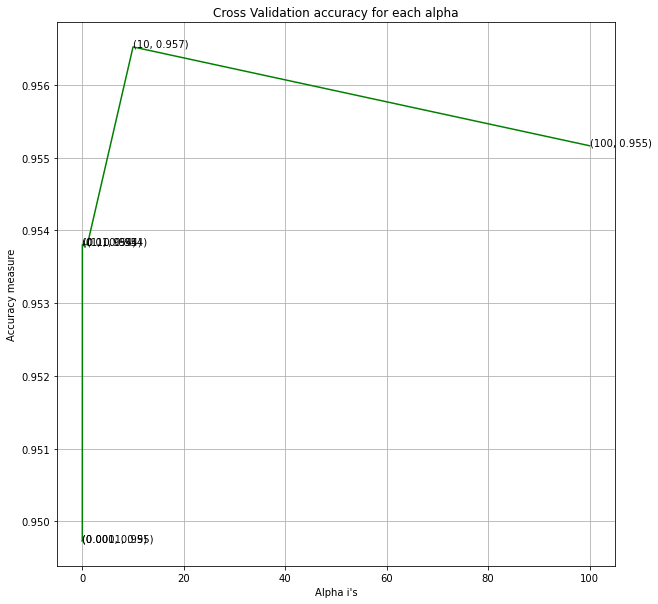

In [25]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.941304347826087
Precision on test data for final baseline model 0.9282700421940928
Recall on test data for final baseline model 0.9565217391304348
-------------------------------------------------- Confusion matrix --------------------------------------------------


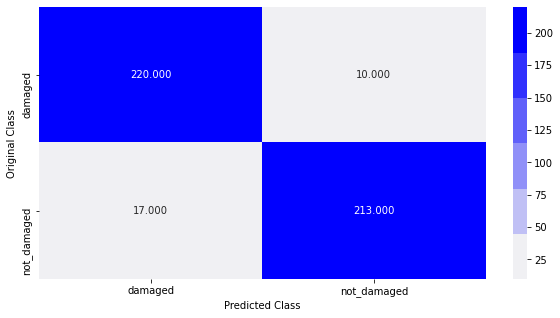

In [26]:

#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'resnet/resnet_stage1_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
precision,recall = compute_precision_recall(y_test,predict_y)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_test,predict_y,stage1_class_labels)

In [27]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage1_baseline','Accuracy':'0.941','Precision':'0.928','Recall':'0.956'},ignore_index= True)

### Stage 2

In [24]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

In [25]:
train_feat,test_feat,train_fd,test_fd = model_features(model_resnet,train_data_dir, test_data_dir)

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [26]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [27]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [28]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

 14%|████████████                                                                        | 1/7 [00:35<03:34, 35.78s/it]C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 29%|████████████████████████                                                            | 2/7 [01:19<03:11, 38.30s/it]C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as sho

Accuracy for alpha 0.0001 is  0.8934010152284264
Accuracy for alpha 0.001 is  0.9010152284263959
Accuracy for alpha 0.01 is  0.9086294416243654
Accuracy for alpha 0.1 is  0.9035532994923858
Accuracy for alpha 1 is  0.9010152284263959
Accuracy for alpha 10 is  0.8883248730964467
Accuracy for alpha 100 is  0.8934010152284264


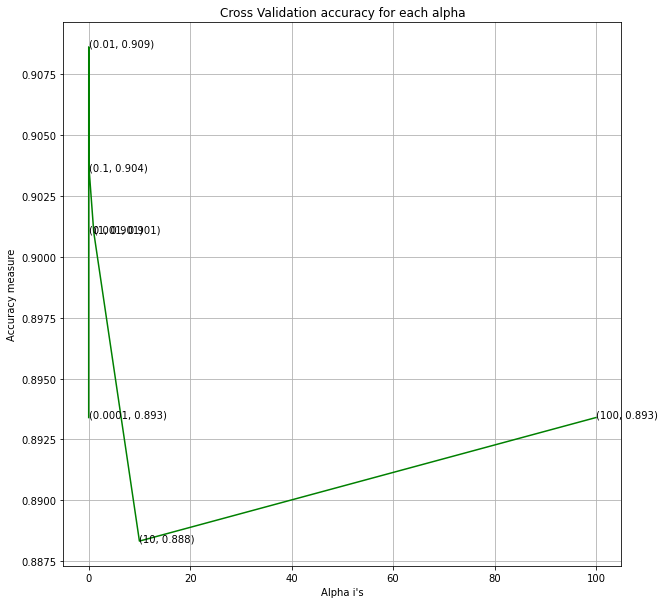

In [29]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.770949720670391
Average Precision is 0.783515872060673
Average Recall is 0.7665164278591298
-------------------------------------------------- Confusion Matrix --------------------------------------------------


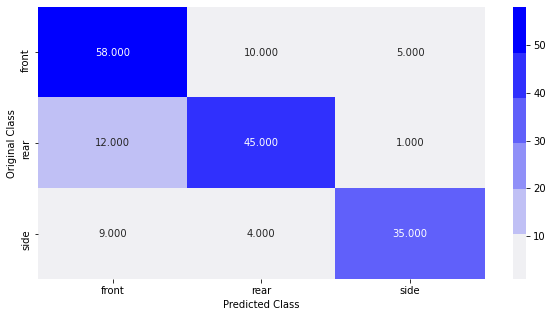

-------------------------------------------------- Precision Matrix --------------------------------------------------


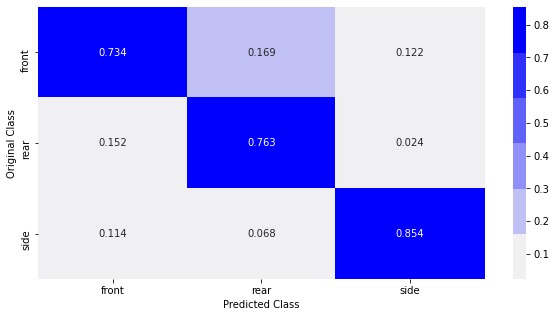

-------------------------------------------------- Recall Matrix --------------------------------------------------


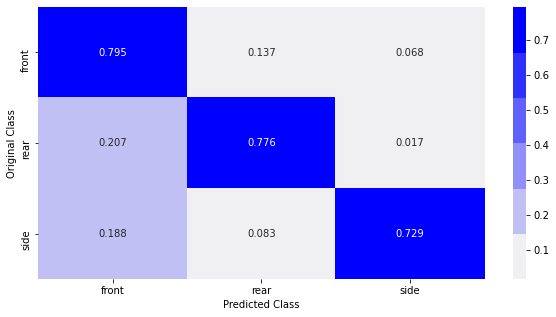

In [30]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model 
save_path = 'resnet/resnet_stage2_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage2_class_labels)

In [31]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage2_baseline','Accuracy':'0.770','Precision':'0.783','Recall':'0.766'},ignore_index= True)

### Stage 3

In [32]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

In [33]:
train_feat,test_feat,train_fd,test_fd = model_features(model_resnet,train_data_dir, test_data_dir)

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [34]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [35]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [36]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|████████████                                                                        | 1/7 [00:44<04:28, 44.82s/it]C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as sho

Accuracy for alpha 0.0001 is  0.8290816326530612
Accuracy for alpha 0.001 is  0.8418367346938775
Accuracy for alpha 0.01 is  0.8418367346938775
Accuracy for alpha 0.1 is  0.8469387755102041
Accuracy for alpha 1 is  0.8469387755102041
Accuracy for alpha 10 is  0.8443877551020408
Accuracy for alpha 100 is  0.8443877551020408


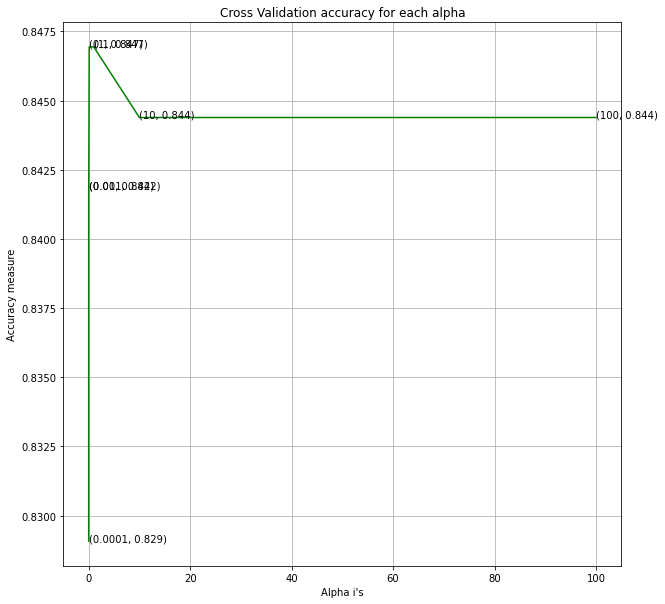

In [37]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.6257309941520468
Average Precision is 0.6252709865365543
Average Recall is 0.6141414141414141
-------------------------------------------------- Confusion Matrix --------------------------------------------------


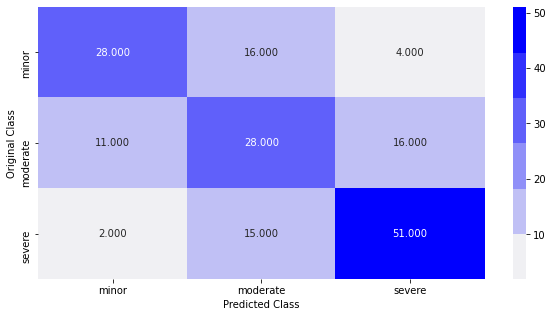

-------------------------------------------------- Precision Matrix --------------------------------------------------


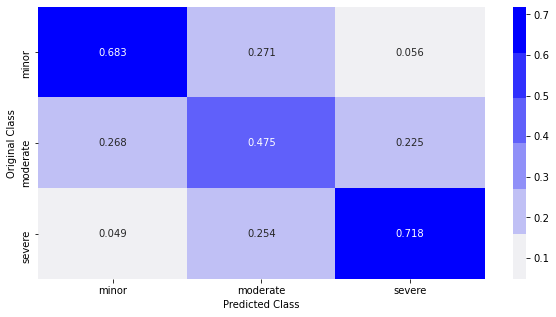

-------------------------------------------------- Recall Matrix --------------------------------------------------


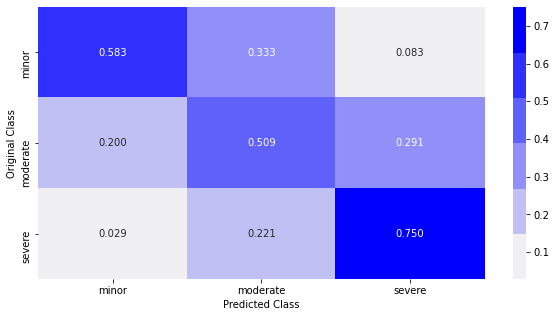

In [38]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'resnet/resnet_stage3_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage3_class_labels)

In [39]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage3_baseline','Accuracy':'0.625','Precision':'0.625','Recall':'0.614'},ignore_index= True)

## CNN (Training FC layer Only)

In [28]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    resnet = applications.ResNet50(include_top=False,weights='imagenet',input_tensor = input_layer)
    resnet = non_trainable(resnet)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(resnet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### stage 1

In [29]:
model = create_model(1,'sigmoid')

In [30]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=["accuracy"])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [32]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage1_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [33]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [34]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [35]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
460/460 [==============================] - 404s 872ms/step - loss: 0.4610 - accuracy: 0.8111 - val_loss: 0.2328 - val_accuracy: 0.9130

Epoch 00001: val_accuracy improved from -inf to 0.91304, saving model to resnet\resnet_stage1_fc-0.913.hdf5


C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
460/460 [==============================] - 388s 844ms/step - loss: 0.1843 - accuracy: 0.9272 - val_loss: 0.2073 - val_accuracy: 0.9217

Epoch 00002: val_accuracy improved from 0.91304 to 0.92174, saving model to resnet\resnet_stage1_fc-0.922.hdf5
Epoch 3/50
460/460 [==============================] - 388s 844ms/step - loss: 0.1133 - accuracy: 0.9595 - val_loss: 0.1999 - val_accuracy: 0.9261

Epoch 00003: val_accuracy improved from 0.92174 to 0.92609, saving model to resnet\resnet_stage1_fc-0.926.hdf5
Epoch 4/50
460/460 [==============================] - 395s 859ms/step - loss: 0.0741 - accuracy: 0.9745 - val_loss: 0.2063 - val_accuracy: 0.9304

Epoch 00004: val_accuracy improved from 0.92609 to 0.93043, saving model to resnet\resnet_stage1_fc-0.930.hdf5
Epoch 5/50
460/460 [==============================] - 384s 834ms/step - loss: 0.0555 - accuracy: 0.9834 - val_loss: 0.2044 - val_accuracy: 0.9261

Epoch 00005: val_accuracy did not improve from 0.93043
Epoch 6/50
460/460 [====

460/460 [==============================] - 386s 839ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2551 - val_accuracy: 0.9391

Epoch 00041: val_accuracy did not improve from 0.94130
Epoch 42/50
460/460 [==============================] - 388s 844ms/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.2593 - val_accuracy: 0.9413

Epoch 00042: val_accuracy did not improve from 0.94130
Epoch 43/50
460/460 [==============================] - 387s 841ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2582 - val_accuracy: 0.9391

Epoch 00043: val_accuracy did not improve from 0.94130
Epoch 44/50
460/460 [==============================] - 389s 845ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 0.2623 - val_accuracy: 0.9413

Epoch 00044: val_accuracy did not improve from 0.94130
Epoch 45/50
460/460 [==============================] - 388s 843ms/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.2596 - val_accuracy: 0.9391

Epoch 00045: val_accuracy did not improve from 0.941

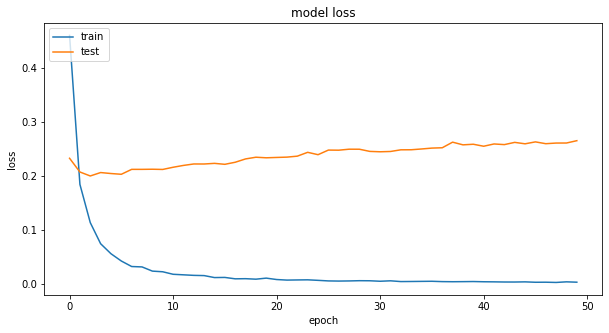

The loss for final model is  0.24383309483528137


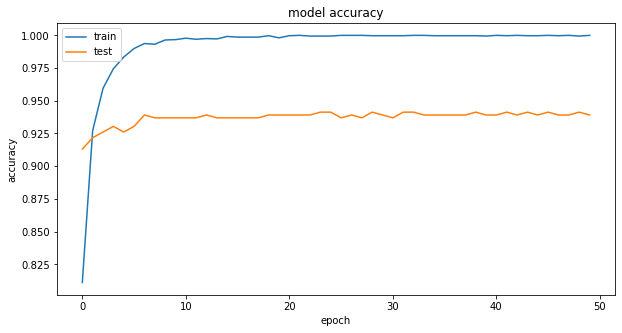

The accuracy for final model is  0.9413043260574341


In [36]:
for i in ['loss','accuracy']:
    plot_metrics(model,i)

In [37]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 460 images belonging to 2 classes.


In [38]:
best_model = load_model('resnet/resnet_stage1_fc-0.941.hdf5')

In [39]:
y_pred = best_model.predict(x_test)

In [40]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
    if i <= .5:
        y_predicted.append('damaged')
    elif i > .5:
        y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.921161825726141
Recall on test data for final baseline model 0.9652173913043478
-------------------------------------------------- Confusion matrix --------------------------------------------------


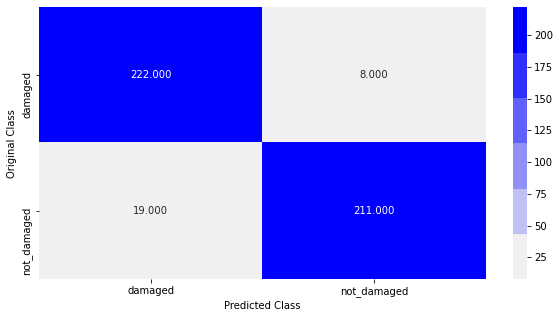

In [41]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [42]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage1 FC','Accuracy':'0.941','Precision':'0.921','Recall':'0.965'},ignore_index= True)

### Stage 2

In [55]:
model = create_model(3,'softmax')

In [56]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=["accuracy"])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [58]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage2_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [59]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [60]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [61]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
246/246 [==============================] - 208s 833ms/step - loss: 1.3487 - accuracy: 0.5203 - val_loss: 0.8054 - val_accuracy: 0.6369

Epoch 00001: val_accuracy improved from -inf to 0.63687, saving model to resnet\resnet_stage2_fc-0.637.hdf5


C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
246/246 [==============================] - 207s 841ms/step - loss: 0.5644 - accuracy: 0.7726 - val_loss: 0.7966 - val_accuracy: 0.7039

Epoch 00002: val_accuracy improved from 0.63687 to 0.70391, saving model to resnet\resnet_stage2_fc-0.704.hdf5
Epoch 3/50
246/246 [==============================] - 206s 837ms/step - loss: 0.3385 - accuracy: 0.8701 - val_loss: 0.7838 - val_accuracy: 0.6648

Epoch 00003: val_accuracy did not improve from 0.70391
Epoch 4/50
246/246 [==============================] - 205s 832ms/step - loss: 0.2193 - accuracy: 0.9284 - val_loss: 0.7717 - val_accuracy: 0.6927

Epoch 00004: val_accuracy did not improve from 0.70391
Epoch 5/50
246/246 [==============================] - 204s 829ms/step - loss: 0.1624 - accuracy: 0.9543 - val_loss: 0.7528 - val_accuracy: 0.7039

Epoch 00005: val_accuracy did not improve from 0.70391
Epoch 6/50
246/246 [==============================] - 206s 837ms/step - loss: 0.1178 - accuracy: 0.9670 - val_loss: 0.7898 - val_accurac


Epoch 00041: val_accuracy did not improve from 0.74302
Epoch 42/50
246/246 [==============================] - 202s 821ms/step - loss: 0.0197 - accuracy: 0.9959 - val_loss: 0.8116 - val_accuracy: 0.7263

Epoch 00042: val_accuracy did not improve from 0.74302
Epoch 43/50
246/246 [==============================] - 202s 821ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.8536 - val_accuracy: 0.7374

Epoch 00043: val_accuracy did not improve from 0.74302
Epoch 44/50
246/246 [==============================] - 202s 821ms/step - loss: 0.0133 - accuracy: 0.9964 - val_loss: 0.8195 - val_accuracy: 0.7430

Epoch 00044: val_accuracy did not improve from 0.74302
Epoch 45/50
246/246 [==============================] - 202s 821ms/step - loss: 0.0174 - accuracy: 0.9954 - val_loss: 0.8153 - val_accuracy: 0.7318

Epoch 00045: val_accuracy did not improve from 0.74302
Epoch 46/50
246/246 [==============================] - 203s 823ms/step - loss: 0.0129 - accuracy: 0.9980 - val_loss: 0.8359 - val_ac

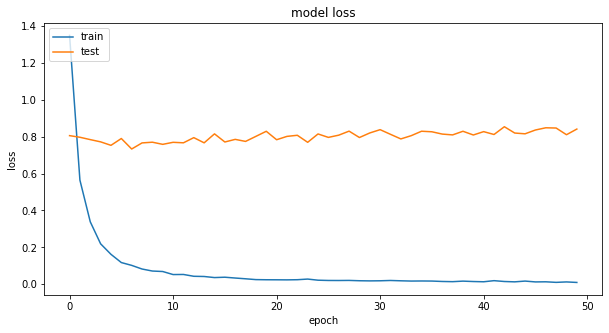

The loss for final model is  0.8073237538337708


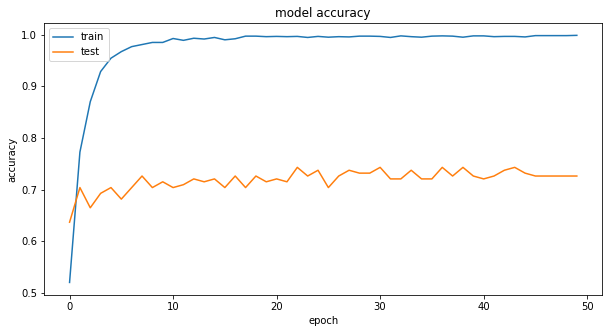

The accuracy for final model is  0.74301677942276


In [62]:
for i in ['loss','accuracy']:
    plot_metrics(model,i)

In [63]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [64]:
best_model = load_model('resnet/resnet_stage2_fc-0.743.hdf5')

In [65]:
y_pred = best_model.predict(x_test)

In [66]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
    n = np.argmax(i)
    if n == 0:
        y_predicted.append('front')
    elif n== 1:
        y_predicted.append('rear')
    elif n == 2:
        y_predicted.append('side')

Average Precision is 0.7859477124183005
Average Recall is 0.7294651760877552
-------------------------------------------------- Confusion Matrix --------------------------------------------------


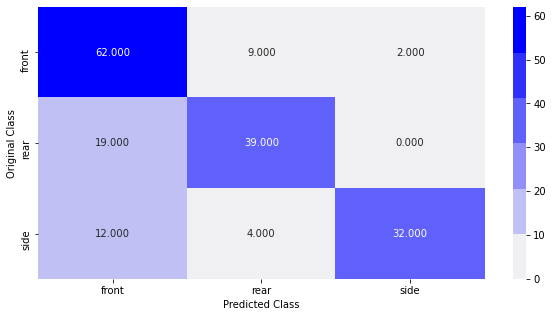

-------------------------------------------------- Precision Matrix --------------------------------------------------


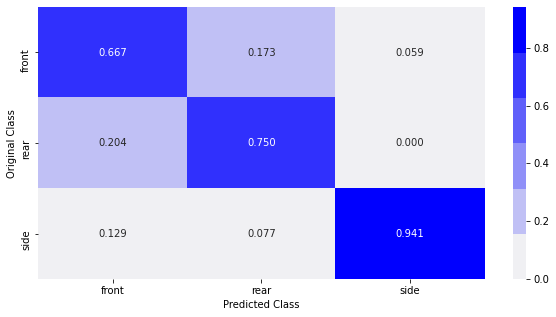

-------------------------------------------------- Recall Matrix --------------------------------------------------


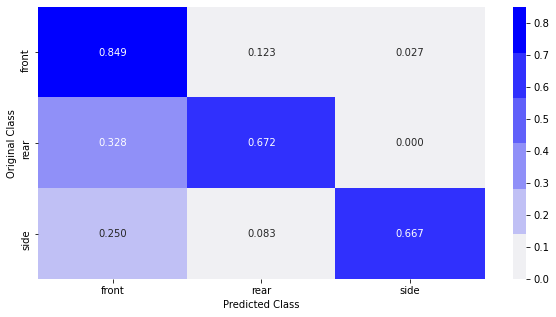

In [67]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [68]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage2 FC','Accuracy':'0.743','Precision':'0.786','Recall':'0.729'},ignore_index= True)

### Stage 3

In [69]:
model = create_model(3,'softmax')

In [70]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=["accuracy"])

In [71]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [72]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage3_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [73]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [74]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [75]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
244/244 [==============================] - 204s 822ms/step - loss: 1.2991 - accuracy: 0.5031 - val_loss: 0.8821 - val_accuracy: 0.5965

Epoch 00001: val_accuracy improved from -inf to 0.59649, saving model to resnet\resnet_stage3_fc-0.596.hdf5


C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
244/244 [==============================] - 201s 820ms/step - loss: 0.5657 - accuracy: 0.7722 - val_loss: 0.8970 - val_accuracy: 0.5731

Epoch 00002: val_accuracy did not improve from 0.59649
Epoch 3/50
244/244 [==============================] - 200s 819ms/step - loss: 0.3559 - accuracy: 0.8652 - val_loss: 0.8895 - val_accuracy: 0.6316

Epoch 00003: val_accuracy improved from 0.59649 to 0.63158, saving model to resnet\resnet_stage3_fc-0.632.hdf5
Epoch 4/50
244/244 [==============================] - 201s 821ms/step - loss: 0.2580 - accuracy: 0.9132 - val_loss: 0.8658 - val_accuracy: 0.6433

Epoch 00004: val_accuracy improved from 0.63158 to 0.64327, saving model to resnet\resnet_stage3_fc-0.643.hdf5
Epoch 5/50
244/244 [==============================] - 200s 817ms/step - loss: 0.1909 - accuracy: 0.9402 - val_loss: 0.8723 - val_accuracy: 0.6374

Epoch 00005: val_accuracy did not improve from 0.64327
Epoch 6/50
244/244 [==============================] - 201s 820ms/step - loss: 0.

244/244 [==============================] - 208s 852ms/step - loss: 0.0112 - accuracy: 0.9990 - val_loss: 1.0891 - val_accuracy: 0.6491

Epoch 00041: val_accuracy did not improve from 0.67251
Epoch 42/50
244/244 [==============================] - 227s 926ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 1.0923 - val_accuracy: 0.6667

Epoch 00042: val_accuracy did not improve from 0.67251
Epoch 43/50
244/244 [==============================] - 230s 941ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 1.1050 - val_accuracy: 0.6433

Epoch 00043: val_accuracy did not improve from 0.67251
Epoch 44/50
244/244 [==============================] - 232s 946ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.1090 - val_accuracy: 0.6550

Epoch 00044: val_accuracy did not improve from 0.67251
Epoch 45/50
244/244 [==============================] - 233s 951ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 1.1227 - val_accuracy: 0.6433

Epoch 00045: val_accuracy did not improve from 0.672

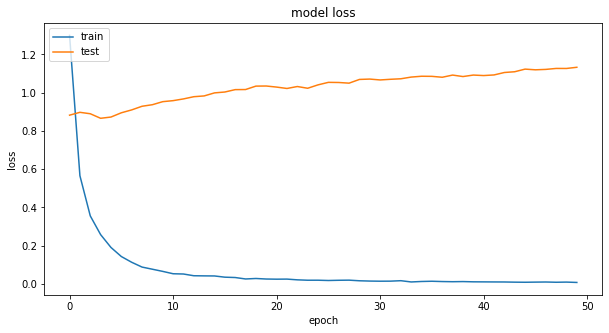

The loss for final model is  1.0661333799362183


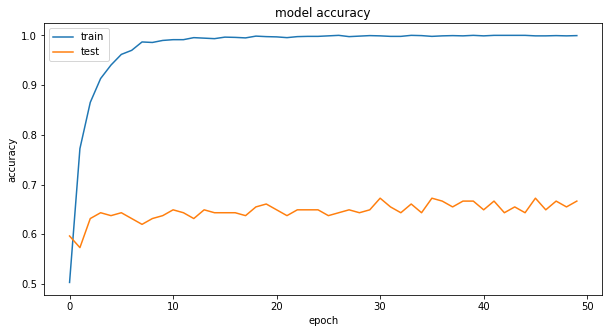

The accuracy for final model is  0.6725146174430847


In [76]:
for i in ['loss','accuracy']:
    plot_metrics(model,i)

In [77]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [78]:
best_model = load_model('resnet/resnet_stage3_fc-0.673.hdf5')

In [79]:
y_pred = best_model.predict(x_test)

In [80]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
    n = np.argmax(i)
    if n == 0:
        y_predicted.append('minor')
    elif n== 1:
        y_predicted.append('moderate')
    elif n == 2:
        y_predicted.append('severe')

Average Precision is 0.66489018358232
Average Recall is 0.6667706476530005
-------------------------------------------------- Confusion Matrix --------------------------------------------------


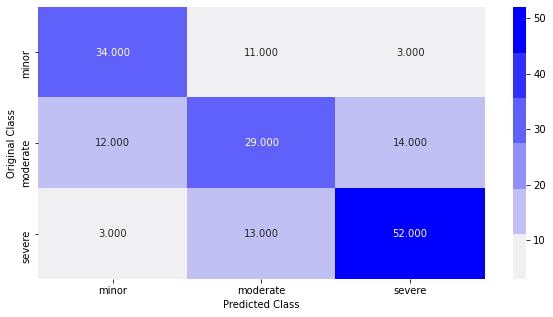

-------------------------------------------------- Precision Matrix --------------------------------------------------


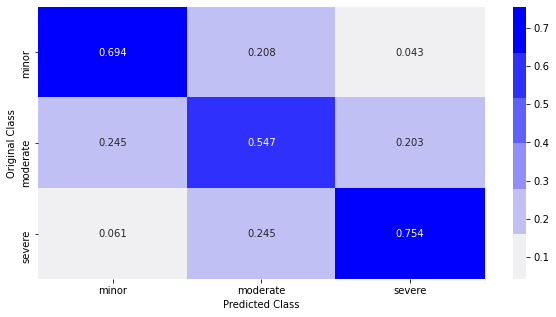

-------------------------------------------------- Recall Matrix --------------------------------------------------


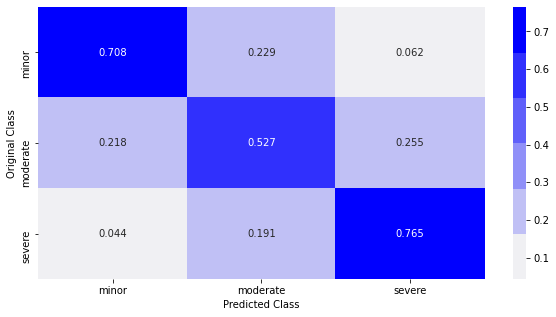

In [81]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [82]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage3 all','Accuracy':'0.672','Precision':'0.665','Recall':'0.666'},ignore_index= True)

In [83]:
resnet_scores.to_csv('resnet_scores.csv',index=False)

In [2]:
final_model = load_model('resnet/resnet_stage1_fc-0.941.hdf5')

not_damaged


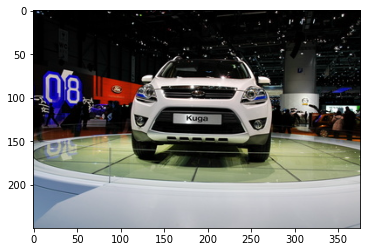

In [5]:
#image_path = "D:/Aegis School of Data Science/Capstone_Project/Input/new_car.jpeg"
image_path = "D:/Aegis School of Data Science/Capstone_Project/epfl-gims08/tripod-seq/tripod_seq_01_051.jpg"
img = cv2.imread(image_path)

plt.imshow(img)

img = np.true_divide(img, 255)
img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
img = img.reshape(1,256,256,3)

y_pred = final_model.predict(img)
if y_pred <= .5:
    print('not_damaged')
elif y_pred > .5:
    print('damaged')